In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from wordcloud import WordCloud

from cities.utils.data_loader import ZoningDataset

smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 2000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

full zoning dataset within the period 410
after dropping university 326
after dropping units <= 4 302
unique logging days 146


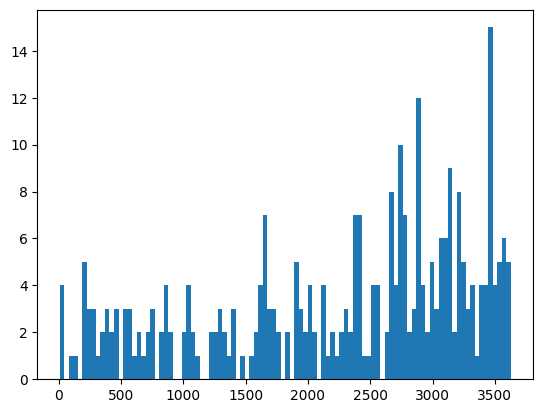

In [2]:
zoning_raw = pd.read_csv(
    os.path.join(root, "data/minneapolis/sourced/per_unit_parking.csv")
)


# drop project name, address
zoning = zoning_raw.drop(columns=["project_name", "address"])

# check nas
nas = zoning.isna().sum()
assert nas.sum() == 0


zoning["date"] = pd.to_datetime(zoning["date"])
start_date = pd.to_datetime("2011-01-01")

zoning["year"] = zoning["date"].dt.year
zoning["year_id"] = pd.factorize(zoning["year"])[0]

# drop year > 2020
zoning = zoning[zoning["year"] <= 2020]

# drop university of minnesota
print("full zoning dataset within the period", len(zoning))
zoning = zoning[zoning["university_yn"] == False]
print("after dropping university", len(zoning))

# drop units <=4
zoning = zoning[zoning["housing_units"].gt(4)]

print("after dropping units <= 4", len(zoning))


zoning["month"] = zoning["date"].dt.month
zoning["day"] = (zoning["date"] - start_date).dt.days


plt.hist(
    zoning["day"], bins=100
)  # note not only within-permit limits but also numbers of permissions is important
# and that the number of permissions is not stationary

print(
    "unique logging days", len(zoning["day"].unique())
)  # note it seems like there have been 153 days with updates,
# reason to believe that the data is not really daily

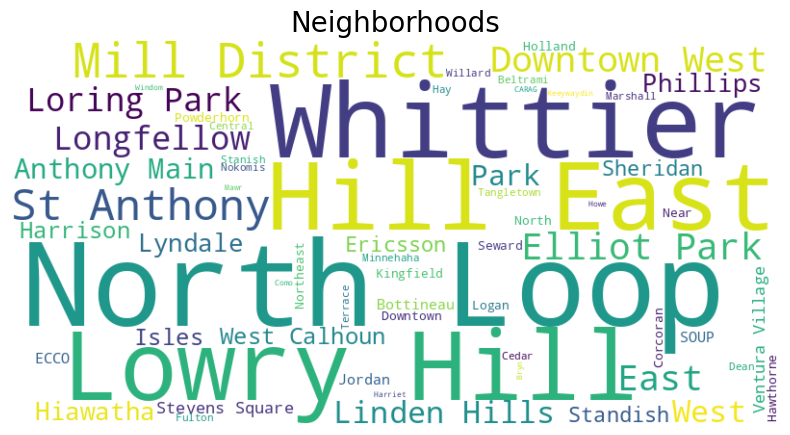

0.7185430463576159


In [3]:
# wordcloud to quickly check for typos
text = " ".join(zoning["neighborhood"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Neighborhoods", fontsize=20)
plt.show()

# note: neighborhoods might be important, perhaps partially because causally related to parcel size?

# parking reform was passed: July 10, 2015
reform = pd.to_datetime("2015-07-10")
reform_day = (reform - start_date).days

zoning["past_reform"] = zoning["date"] > reform

print(
    zoning["past_reform"].mean()
    # note 71 % permits are after the reform
)

In [4]:
criteria = ["past_reform", "res_parking_elim_2015_yn", "res_parking_reduced_2015_yn"]

replacement_dict = {
    "FalseFalseFalse": "full",
    "FalseTrueFalse": "full",
    "FalseFalseTrue": "full",
    "FalseTrueTrue": "full",
    "TrueFalseFalse": "full",
    "TrueTrueFalse": "eliminated",
    "TrueFalseTrue": "reduced",
    "TrueTrueTrue": "eliminated",
}

zoning["limit"] = (
    zoning[criteria].astype(str).agg("".join, axis=1).replace(replacement_dict)
)

zoning.loc[zoning["downtown_yn"], "limit"] = "eliminated"

limit_ordering = ["eliminated", "reduced", "full"]

zoning["limit"] = pd.Categorical(
    zoning["limit"], categories=limit_ordering, ordered=True
)

zoning["limit_id"] = zoning["limit"].cat.codes

# sanity check
print(zoning["limit"].value_counts())

limit
eliminated    186
full           68
reduced        48
Name: count, dtype: int64


In [5]:
criteria = ["downtown_yn", "res_parking_elim_2015_yn", "res_parking_reduced_2015_yn"]


# TODO DOUBLE CHECK THIS
zone_replacement_dict = {
    "FalseFalseFalse": "other_non_university",
    "FalseTrueFalse": "blue_zone",
    "FalseFalseTrue": "yellow_zone",
    "FalseTrueTrue": "blue_zone",
    "TrueFalseFalse": "downtown",
    "TrueTrueFalse": "downtown",
    "TrueFalseTrue": "downtown",
    "TrueTrueTrue": "downtown",
}

zoning["zone"] = (
    zoning[criteria].astype(str).agg("".join, axis=1).replace(zone_replacement_dict)
)

zoning_ordering = ["downtown", "blue_zone", "yellow_zone", "other_non_university"]

zoning["zone"] = pd.Categorical(
    zoning["zone"], categories=zoning_ordering, ordered=True
)

zoning["zone_id"] = zoning["zone"].cat.codes

# sanity check
print(zoning["zone"].value_counts())

# Ria's definitions, to be mirrored by the replacement dict above
# downtown_df = df[df['downtown_yn']]
# blue_zone_df = df[df['res_parking_elim_2015_yn'] & ~df['downtown_yn']]

# yellow_zone_df = df[df['res_parking_reduced_2015_yn'] & ~df['res_parking_elim_2015_yn'] & ~df['downtown_yn']]
# other_non_university_df = df[~df['res_parking_elim_2015_yn'] & ~df['res_parking_reduced_2015_yn'] & ~df['downtown_yn']]
# (edited)

zone
blue_zone               125
downtown                 90
yellow_zone              57
other_non_university     30
Name: count, dtype: int64


neigh [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
wards [ 0  1  2  3  4  5  6  7  8  9 10 11]


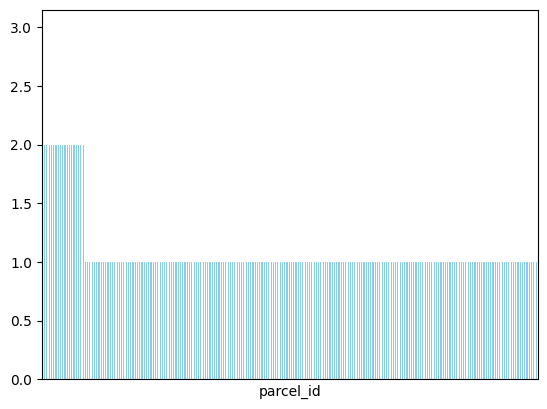

In [6]:
columns_to_factorize = ["year", "month", "day", "neighborhood", "ward"]

for column in columns_to_factorize:
    zoning[column + "_id"] = pd.factorize(zoning[column])[0]


print("neigh", zoning["neighborhood_id"].unique())
print("wards", zoning["ward_id"].unique())
# 76 neighborhoods, 13 wards


# note one or two permits per parcel, no strong reason to use parcels as units of analysis
zoning["parcel_id"].value_counts().plot(kind="bar", color="skyblue")
plt.xticks([])
plt.show()

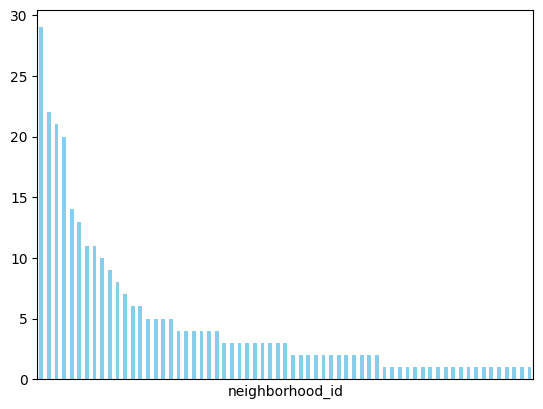

,parcel_id,date,neighborhood,ward,downtown_yn,housing_units,car_parking,bike_parking,parcel_area,university_yn,...,limit_id,zone,zone_id,month_id,day_id,neighborhood_id,ward_id,housing_units_std,car_parking_std,parcel_area_std
0,2602924310063,2011-01-10,Elliot Park,6,True,7,0,0,7245.893155,False,...,0,downtown,0,0,0,0,0,-0.966018,-0.874411,-0.653776
1,102824440106,2011-01-10,Stanish Ericsson,12,False,64,74,80,38210.631831,False,...,2,blue_zone,1,0,0,1,1,-0.412934,-0.172823,-0.035057
2,2702924430325,2011-01-10,Stevens Square,6,False,123,104,62,73747.490123,False,...,2,blue_zone,1,0,0,2,0,0.159557,0.111605,0.675019
3,3302924440363,2011-02-07,Lowry Hill East,10,False,198,240,108,70847.105465,False,...,2,blue_zone,1,1,1,3,2,0.887299,1.401010,0.617065
5,1702823340059,2011-04-11,Nokomis East,12,False,42,42,21,52590.828770,False,...,2,other_non_university,3,2,2,4,1,-0.626405,-0.476212,0.252279


{'housing_units': {'mean': 106.55629139072848, 'std': 103.05845425538602}, 'car_parking': {'mean': 92.22847682119205, 'std': 105.47499325900824}, 'parcel_area': {'mean': 39965.12336015361, 'std': 50046.55803914138}}


In [7]:
# we might have a shot with neighborhoods as units of analysis
zoning["neighborhood_id"].value_counts().plot(kind="bar", color="skyblue")
plt.xticks([])
plt.show()


columns_to_standardize = ["housing_units", "car_parking", "parcel_area"]

standardization_dict = {}

for column in columns_to_standardize:
    zoning[column + "_std"] = (zoning[column] - zoning[column].mean()) / zoning[
        column
    ].std()
    standardization_dict[column] = {
        "mean": zoning[column].mean(),
        "std": zoning[column].std(),
    }

display(zoning.head())

print(standardization_dict)

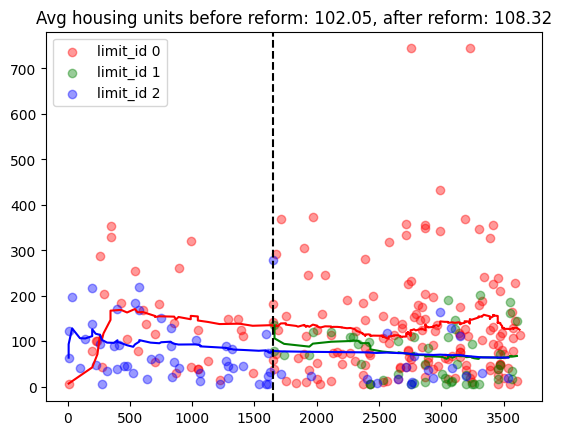

In [8]:
window_size = 60

rolling_avgs = {}
for limit_id, group in zoning.groupby("limit_id"):
    rolling_avgs[limit_id] = (
        group["housing_units"].rolling(window_size, min_periods=1).mean()
    )

rolling_total = zoning["housing_units"].rolling(window_size, min_periods=1).sum()
rolling_avg = zoning["housing_units"].rolling(window_size, min_periods=1).mean()


for limit_id, color in enumerate(["red", "green", "blue"]):
    plt.scatter(
        x=zoning[zoning["limit_id"] == limit_id]["day"],
        y=zoning[zoning["limit_id"] == limit_id]["housing_units"],
        alpha=0.4,
        c=color,
        label=f"limit_id {limit_id}",
    )
    plt.plot(
        zoning[zoning["limit_id"] == limit_id]["day"], rolling_avgs[limit_id], c=color
    )

plt.axvline(reform_day, color="black", linestyle="--")

# possibly plot running total sum, seems to be an increase after the reform
# plt.plot(zoning['day'], rolling_total, c='black', label='total', linestyle='--')

# possibly plot running average
# average permit size does not increase too much
# plt.plot(zoning['day'], rolling_avg, c='black', label='total', linestyle='--')

# average before reform
avg_before = zoning[zoning["day"] < reform_day]["housing_units"].mean()
avg_after = zoning[zoning["day"] >= reform_day]["housing_units"].mean()

plt.title(
    f"Avg housing units before reform: {avg_before:.2f}, after reform: {avg_after:.2f}"
)
plt.legend()
plt.show()

# note the red line doesn't have to upwards to show that the lower limits have effect

# also: think hard what it is that we care about trying to predict, there are many ways to conceptualize the problem

# for now, the question we're trying to aswer is: what is the effect of limit class on the number of housing units

# note initial and final periods might have laged/incomplete data,

In [9]:
# Ria's data transformation
# df = pd.read_csv("per_unit_parking.csv")
# df = df[~df['university_yn'] & df['housing_units'].gt(4)] # excluding university area, and interventions only apply for >4 unit permits
# downtown_df = df[df['downtown_yn']]
# blue_zone_df = df[df['res_parking_elim_2015_yn'] & ~df['downtown_yn']]
# yellow_zone_df = df[df['res_parking_reduced_2015_yn'] & ~df['res_parking_elim_2015_yn'] & ~df['downtown_yn']]
# other_non_university_df = df[~df['res_parking_elim_2015_yn'] & ~df['res_parking_reduced_2015_yn'] & ~df['downtown_yn']]
# (edited)

# The yellow zone above excludes the blue (parking-eliminated)
# zone, but the fully inclusive yellow zone is below:
# yellow_zone_inclusive_df = df[df['res_parking_reduced_2015_yn'] & ~df['downtown_yn']]
# 1:11
# More useful context:
# Blue zone is area within 350  ft of high-frequency transit,
# and yellow zone  is area within 0.25 miles of high-frequency
# transit, plus 0.5 miles around high frequency rail stops.

In [10]:
zoning.columns

Index(['parcel_id', 'date', 'neighborhood', 'ward', 'downtown_yn',
       'housing_units', 'car_parking', 'bike_parking', 'parcel_area',
       'university_yn', 'res_parking_elim_2015_yn',
       'res_parking_reduced_2015_yn', 'year', 'year_id', 'month', 'day',
       'past_reform', 'limit', 'limit_id', 'zone', 'zone_id', 'month_id',
       'day_id', 'neighborhood_id', 'ward_id', 'housing_units_std',
       'car_parking_std', 'parcel_area_std'],
      dtype='object')

In [11]:
# tensor prep

# categorical
parcel_id = torch.tensor(zoning["parcel_id"].values, dtype=torch.long)
neighborhood_id = torch.tensor(zoning["neighborhood_id"].values, dtype=torch.long)
ward_id = torch.tensor(zoning["ward_id"].values, dtype=torch.long)
zone_id = torch.tensor(zoning["zone_id"].values, dtype=torch.long)
limit_id = torch.tensor(zoning["limit_id"].values, dtype=torch.long)
past_reform = torch.tensor(zoning["past_reform"].values, dtype=torch.long)


year = torch.tensor(zoning["year"].values, dtype=torch.long)
month = torch.tensor(zoning["month_id"].values, dtype=torch.long)
day = torch.tensor(zoning["day"].values, dtype=torch.long)


# continuous

# keep the orginals for interpretable evaluation
parcel_area_original = torch.tensor(zoning["parcel_area"].values, dtype=torch.float)
car_parking_original = torch.tensor(zoning["car_parking"].values, dtype=torch.float)
housing_units_original = torch.tensor(zoning["housing_units"].values, dtype=torch.float)


parcel_area = torch.tensor(zoning["parcel_area_std"].values, dtype=torch.float)
car_parking = torch.tensor(zoning["car_parking_std"].values, dtype=torch.float)
housing_units = torch.tensor(zoning["housing_units_std"].values, dtype=torch.float)


categorical = {
    "parcel_id": parcel_id,
    "neighborhood_id": neighborhood_id,
    "ward_id": ward_id,
    "zone_id": zone_id,
    "limit_id": limit_id,
    "past_reform": past_reform,
}

continuous = {
    "parcel_area": parcel_area,
    "car_parking": car_parking,
    "housing_units": housing_units,
    "parcel_are_original": parcel_area_original,
    "car_parking_original": car_parking_original,
    "housing_units_original": housing_units_original,
}

In [12]:
zoning_dataset = ZoningDataset(
    categorical, continuous, standardization_dictionary=standardization_dict
)

zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

torch.save(zoning_dataset, zoning_data_path)

In [13]:
zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=4, shuffle=True
)  # , collate_fn=zoning_dataset_read.collate)

for batch in zoning_loader:
    print(batch)
    break

{'categorical': {'parcel_id': tensor([2302924210089, 1502924140114, 1202824210260, 3402924110148]), 'neighborhood_id': tensor([42, 21, 45, 32]), 'ward_id': tensor([4, 4, 1, 2]), 'zone_id': tensor([1, 2, 1, 2]), 'limit_id': tensor([0, 1, 0, 1]), 'past_reform': tensor([1, 1, 1, 1])}, 'continuous': {'parcel_area': tensor([-0.4289, -0.6650, -0.4147, -0.5662]), 'car_parking': tensor([-0.5995, -0.4288, -0.5805, -0.8175]), 'housing_units': tensor([-0.5585,  0.0334, -0.4226, -0.8496]), 'parcel_are_original': tensor([18501.6270,  6683.4785, 19208.3789, 11630.2705]), 'car_parking_original': tensor([29., 47., 31.,  6.]), 'housing_units_original': tensor([ 49., 110.,  63.,  19.])}}
